In [1]:
import matplotlib
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import numpy as np
import fastprop
import os
from rdkit import Chem
import scipy
from matplotlib import cm
from matplotlib.colors import Normalize 
from scipy.stats import wasserstein_distance
from sklearn.metrics import mean_squared_error 
from sklearn.metrics import mean_absolute_error
import seaborn as sns
import warnings
warnings.filterwarnings('ignore', category=RuntimeWarning)
colors = sns.color_palette(palette='Accent').as_hex()

matplotlib.rcParams.update({'font.style': 'normal'})
matplotlib.rcParams.update({'font.sans-serif': 'Segoe UI'})
matplotlib.rcParams.update({'font.size': 26})

In [2]:
def gradient_analysis(df):
    grouped_predictions = df.groupby(['solvent smiles', 'solute smiles'])
    # Create a list of smaller dataframes
    sub_dfs = [group for _, group in grouped_predictions]

    total_predicted_gradients = []
    total_true_gradients = []
    for df in sub_dfs:
        if(len(df) > 1):
            total_true_gradients.append(np.gradient(df['logS_true'], df['temperature']).flatten())
            total_predicted_gradients.append(np.gradient(df['logS_pred'], df['temperature']).flatten())
    
    true_grads = np.concatenate(total_true_gradients).ravel()
    pred_grads = np.concatenate(total_predicted_gradients).ravel()
    mask = np.isfinite(true_grads) & np.isfinite(pred_grads) 
    true_grads = true_grads[mask]
    pred_grads = pred_grads[mask]
    
    mse = mean_squared_error(true_grads, pred_grads)
    mae = mean_absolute_error(true_grads, pred_grads)

    return true_grads, pred_grads, mse, mae

def gradient_parity_plot(true_grads, pred_grads):
    plt.figure(figsize=[6.4,4.8])
    fig, ax1 = plt.subplots()

    bins = [100, 100] # number of bins
    hh, locx, locy = np.histogram2d(true_grads, pred_grads, bins=bins, density = True)

    # Sort the points by density, so that the densest points are plotted last
    z = np.array([hh[np.argmax(a<=locx[1:]),np.argmax(b<=locy[1:])] for a,b in zip(true_grads, pred_grads)])
    idx = z.argsort()
    x2, y2, z2 = true_grads[idx], pred_grads[idx], z[idx]


    ax1.scatter(true_grads,pred_grads, c = z2, alpha =0.4, edgecolors = 'black')
    ax1.plot([-1, 1], [-1,1], linestyle = '-', linewidth = 3, color = 'black')

    norm = Normalize(vmin = np.min(z), vmax = np.max(z))
    cbar = fig.colorbar(cm.ScalarMappable(norm = norm), ax=ax1)
    cbar.ax.set_ylabel('Density')


    ax1.set_xlim([-0.1, 0.1])
    ax1.set_ylim([-0.1, 0.1])
    ax1.set_ylabel(r"$\frac{\hat{dlogS}}{dT}$")
    ax1.set_xlabel(r"$\frac{dlogS}{dT}$")
    ax1.legend(prop={'size': 22}, loc = 'upper left', frameon = False) 
    ax1.spines[['right', 'top']].set_visible(False)
    return ax1

def pdf_plot(true_grads, pred_grads, bins):
    true_grads_binned, true_grad_bins = np.histogram(true_grads, bins = bins, range = (-0.05, 0.05))
    pred_grads_binned, pred_grad_bins = np.histogram(pred_grads, bins = bins, range = (-0.05, 0.05))

    plt.figure(figsize=[6.4,4.8])
    ax1 = plt.gca()

    ax1.stairs(true_grads_binned, true_grad_bins, label = r'ground truth')
    ax1.stairs(pred_grads_binned,pred_grad_bins, label = r'predictions')
    #ax1.set_xlim([-0.05, 0.05])
    #ax1.set_ylim([-500, 22000])
    ax1.set_ylabel(r"Count")
    ax1.set_xlabel(r"$\frac{dlogS}{dT}$")
    ax1.legend(prop={'size': 22}, loc = 'upper right', frameon = False) 
    ax1.spines[['right', 'top']].set_visible(False)
    return ax1, true_grads_binned, pred_grads_binned, true_grad_bins, pred_grad_bins

def cdf_plot(true_grads, pred_grads, bins): 
    # Compute histograms
    true_grads_binned, true_grad_bins = np.histogram(true_grads, bins=bins, range = (-0.05, 0.05))
    pred_grads_binned, pred_grad_bins = np.histogram(pred_grads, bins=bins, range = (-0.05, 0.05))

    # Compute the CDF
    true_grads_cdf = np.cumsum(true_grads_binned) / np.sum(true_grads_binned)
    pred_grads_cdf = np.cumsum(pred_grads_binned) / np.sum(pred_grads_binned)

    distance = wasserstein_distance(true_grads_cdf, pred_grads_cdf)

    # Create the plot
    plt.figure(figsize=[6.4, 4.8])
    ax1 = plt.gca()

    # Plot the CDFs as step plots
    ax1.step(true_grad_bins[:-1], true_grads_cdf, where='post', label='ground truth')
    ax1.step(pred_grad_bins[:-1], pred_grads_cdf, where='post', label='predictions')   
    ax1.text(0.02, 0.2, f"EMD = {distance:.2f}", color = 'orange')
    # Set axis limits
    ax1.set_ylim([0, 1])
    ax1.set_yticks([0,0.5 ,1])

    ax1.set_ylabel("Cumulative Probability")
    ax1.set_xlabel(r"$\frac{dlogS}{dT}$")
    ax1.legend(prop={'size': 22}, loc='upper left', frameon=False)
    ax1.spines[['right', 'top']].set_visible(False)
    return ax1, true_grads_cdf, pred_grads_cdf, distance, true_grad_bins, pred_grad_bins
def stats(true, predicted): 
    mse = mean_squared_error(true, predicted)

    differences = np.abs(true - predicted)
    within_1_unit = differences <= 1
    percentage_within_1_unit = np.sum(within_1_unit) / len(true) * 100
    return mse, percentage_within_1_unit

def parity_plot(x,y, label, color, mse, percentage_within_1_unit):
    plt.figure(figsize=[6.4,4.8])
    fig, ax1 = plt.subplots()
    ax1.plot([-6, 6], [-6,6], linestyle = '--', linewidth = 2, color = 'black')
    ax1.plot([-6, 6], [-7,5], linestyle = '--', linewidth = 2, color = 'gray', alpha = 0.4)
    ax1.plot([-6, 6], [-5,7], linestyle = '--', linewidth = 2, color = 'gray', alpha = 0.4)
    ax1.scatter(x,y, alpha =0.4, s = 30, edgecolors = 'black', color = color, label = label)
    ax1.set_xlim([-6,3])
    ax1.set_xticks([-6, -3, 0, 3])
    ax1.set_ylim([-6,3])
    ax1.set_yticks([-6, -3, 0, 3])
    ax1.set_ylabel(r"$\hat{logS}$")
    ax1.set_xlabel(r"True $logS$")
    ax1.legend(prop={'size': 20}, loc = 'upper left', frameon = False, bbox_to_anchor=(-0.05,1.1)) 
    ax1.text(-2,-4, f"RMSE = {np.sqrt(mse):.2f}", fontsize = 20)
    ax1.text(-2,-5, '% logS' + r'$\pm$'  + f"1 = {percentage_within_1_unit:.1f}", fontsize = 20)
    ax1.spines[['right', 'top']].set_visible(False)
    return ax1

Fastprop performance on SolProp dataset

In [30]:
_src_dir: str = os.path.join(r"C:\Users\ChemeGrad2021\Documents\highsol", "amended")
solprop_predictions: pd.DataFrame = pd.read_csv(os.path.join(_src_dir, "solprop_nonaq_predictions_fastprop.csv"))
solprop_predictions[['solvent smiles', 'solute smiles']] = solprop_predictions['smiles'].str.split('.', n=1, expand=True)
solprop_predictions
solute_smiles = solprop_predictions.pop('solute smiles')  
solvent_smiles = solprop_predictions.pop('solvent smiles')  

both = solprop_predictions.pop('smiles')  

solprop_predictions.insert(0, 'solvent smiles', solvent_smiles) 
solprop_predictions.insert(0, 'solute smiles', solute_smiles) 


<AxesSubplot: xlabel='True $logS$', ylabel='$\\hat{logS}$'>

<Figure size 640x480 with 0 Axes>

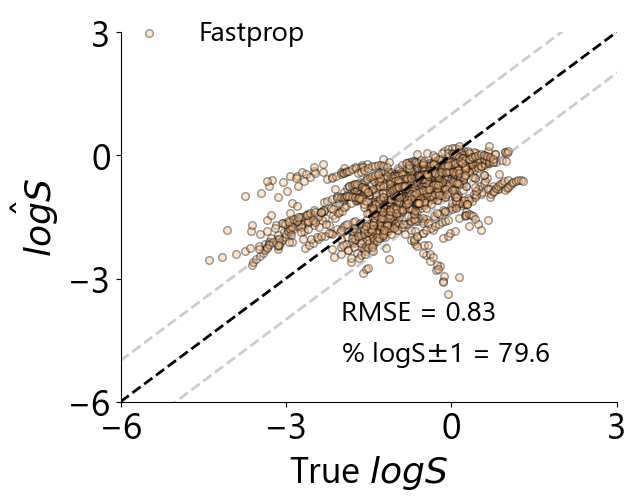

In [31]:
mse_absolute, percentage_within_1_unit = stats(solprop_predictions['logS_true'], solprop_predictions['logS_pred'])
parity_plot(solprop_predictions['logS_true'],
            solprop_predictions['logS_pred'],
            'Fastprop', 
            [colors[2]],
            mse_absolute, 
            percentage_within_1_unit)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Figure size 640x480 with 0 Axes>

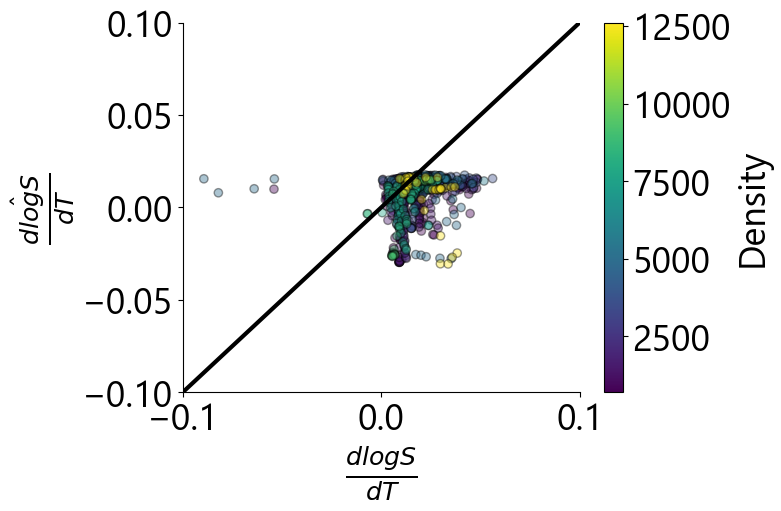

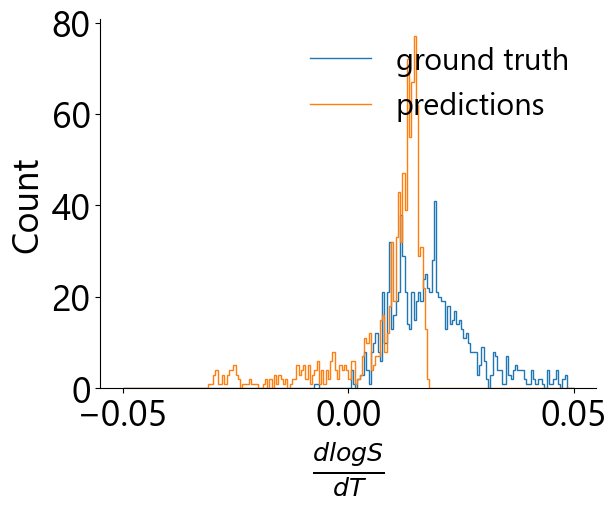

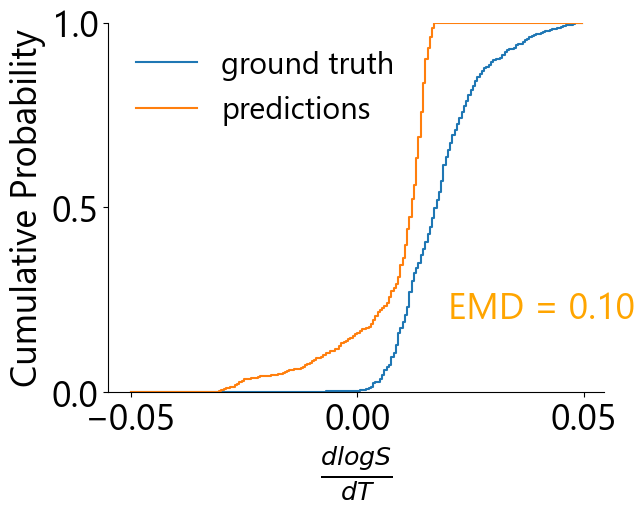

In [32]:
true_grads, pred_grads, mse, mae = gradient_analysis(solprop_predictions)
gradient_parity_plot(true_grads, pred_grads)
ax1, true_grads_binned, pred_grads_binned, true_grad_bins_pdf, pred_grad_bins_pdf = pdf_plot(true_grads, pred_grads, bins =200)
ax2, true_grads_cdf, pred_grads_cdf, distance, true_grad_bins_cdf, pred_grad_bins_cdf = cdf_plot(true_grads, pred_grads, bins = 200)

Fastprop-sobolev predictions on SolProp dataset

In [33]:
_src_dir: str = os.path.join(r"C:\Users\ChemeGrad2021\Documents\highsol", "amended")
fastsolvphys_predictions: pd.DataFrame = pd.read_csv(os.path.join(_src_dir, "solprop_nonaq_predictions_fastprop_sobolev.csv"))
fastsolvphys_predictions[['solvent smiles', 'solute smiles']] = fastsolvphys_predictions['smiles'].str.split('.', n=1, expand=True)
fastsolvphys_predictions
solute_smiles = fastsolvphys_predictions.pop('solute smiles')  
solvent_smiles = fastsolvphys_predictions.pop('solvent smiles')  
both = fastsolvphys_predictions.pop('smiles')  

fastsolvphys_predictions.insert(0, 'solvent smiles', solvent_smiles) 
fastsolvphys_predictions.insert(0, 'solute smiles', solute_smiles) 

<AxesSubplot: xlabel='True $logS$', ylabel='$\\hat{logS}$'>

<Figure size 640x480 with 0 Axes>

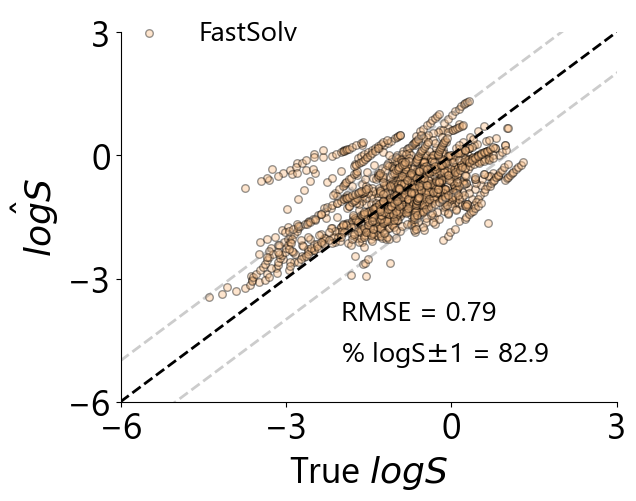

In [34]:
mse_absolute_phys, percentage_within_1_unit_phys = stats(fastsolvphys_predictions['logS_true'], fastsolvphys_predictions['logS_pred'])
parity_plot(fastsolvphys_predictions['logS_true'],
            fastsolvphys_predictions['logS_pred'],
            'FastSolv', 
            [colors[2]],
            mse_absolute_phys, 
            percentage_within_1_unit_phys)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Figure size 640x480 with 0 Axes>

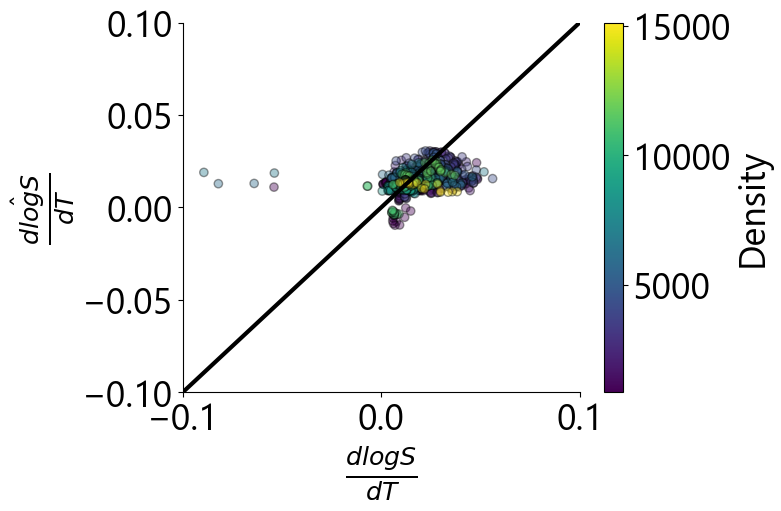

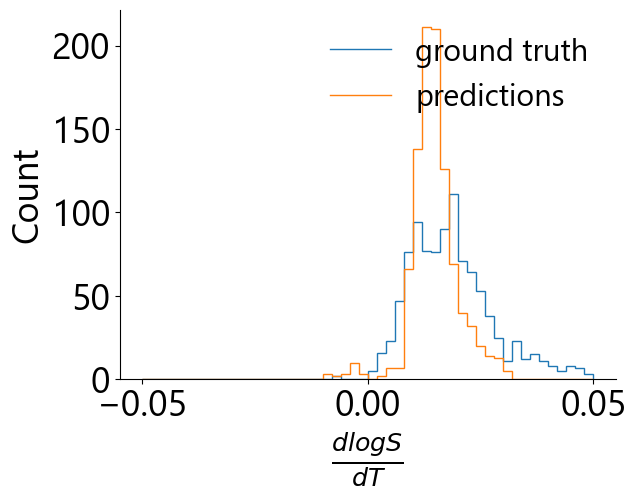

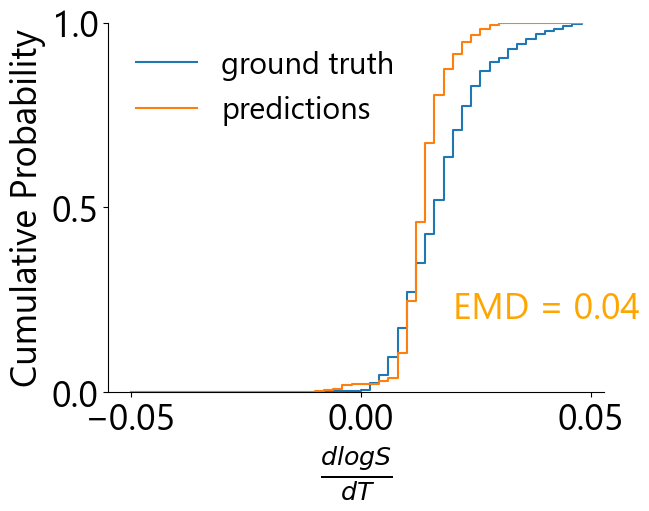

In [41]:
true_grads_phys, pred_grads_phys, mse_phys, mae_phys = gradient_analysis(fastsolvphys_predictions)
gradient_parity_plot(true_grads_phys, pred_grads_phys)
ax1, true_grads_binned_phys, pred_grads_binned_phys, true_grad_bins_pdf_phys, pred_grad_bins_pdf_phys = pdf_plot(true_grads_phys, pred_grads_phys, bins =50)
ax2, true_grads_cdf_phys, pred_grads_cdf_phys, distance_phys, true_grad_bins_cdf_phys, pred_grad_bins_cdf_phys = cdf_plot(true_grads_phys, pred_grads_phys, bins = 50)

In [81]:
distance_phys

0.01885710392074661

SolProp predictions on SolProp dataset

In [36]:
_src_dir: str = os.path.join(r"C:\Users\ChemeGrad2021\Documents\highsol", "amended")
vermiere_solprop_predictions: pd.DataFrame = pd.read_csv(os.path.join(_src_dir, "solprop_nonaq_vermeire_predictions.csv"))
vermiere_solprop_predictions = vermiere_solprop_predictions.rename(columns = {"Solvent": "solvent smiles","Solute": "solute smiles", "Temp" : "temperature"})
solprop_solprop_predictions = solprop_predictions.merge(vermiere_solprop_predictions[['solute smiles', 'solvent smiles', 'temperature', 'logST (method1) [log10(mol/L)]']], 
                on=['solute smiles', 'solvent smiles', 'temperature'], 
                how='left')
solprop_solprop_predictions.pop('logS_pred')
solprop_solprop_predictions.rename(columns = {'logST (method1) [log10(mol/L)]': 'logS_pred'}, inplace=True)

<AxesSubplot: xlabel='True $logS$', ylabel='$\\hat{logS}$'>

<Figure size 640x480 with 0 Axes>

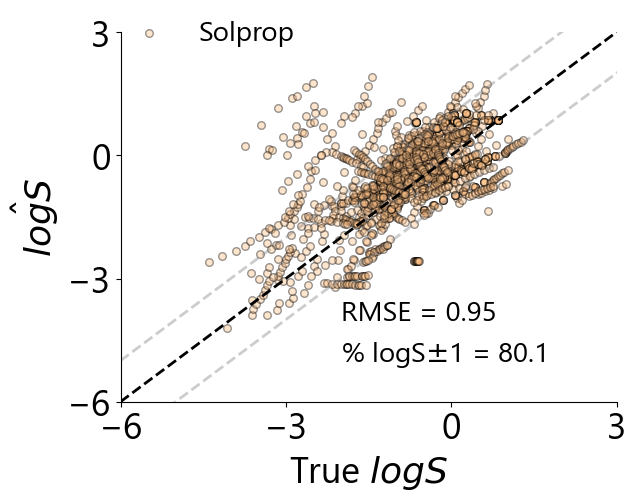

In [37]:
mse_absolute_solprop, percentage_within_1_unit_solprop = stats(solprop_solprop_predictions['logS_true'], solprop_solprop_predictions['logS_pred'])
parity_plot(solprop_solprop_predictions['logS_true'],
            solprop_solprop_predictions['logS_pred'],
            'Solprop', 
            [colors[2]],
            mse_absolute_solprop, 
            percentage_within_1_unit_solprop)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Figure size 640x480 with 0 Axes>

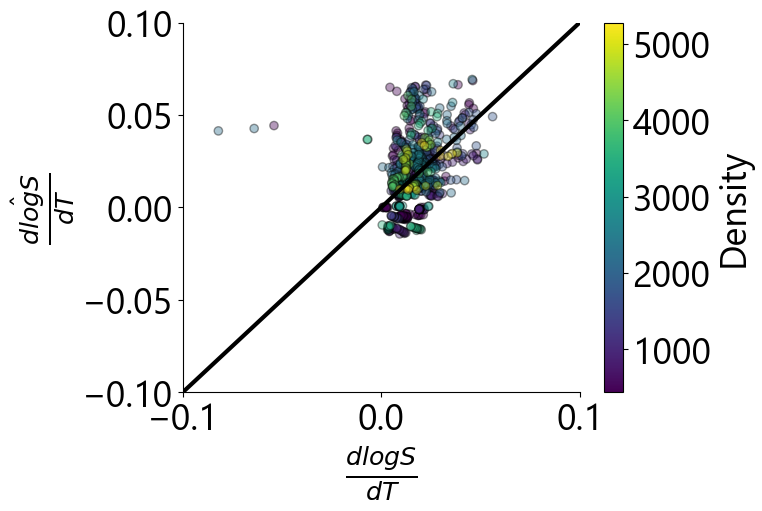

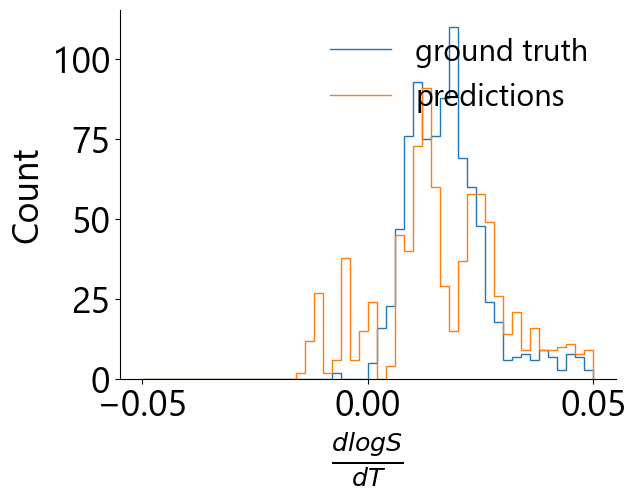

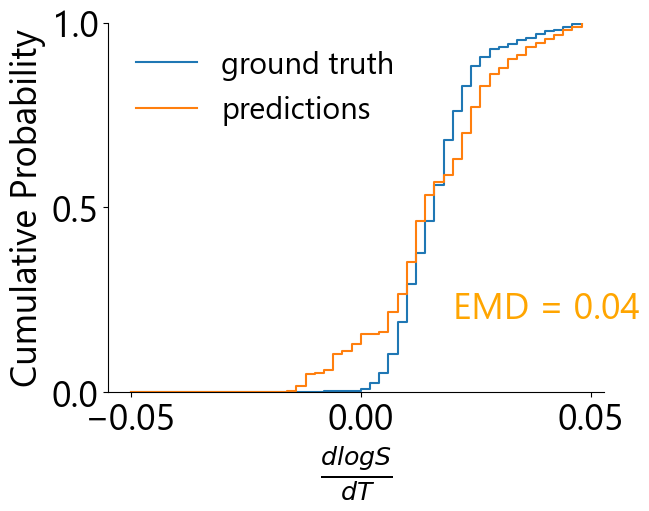

In [40]:
true_grads_solprop, pred_grads_solprop, mse_solprop, mae_solprop = gradient_analysis(solprop_solprop_predictions)
gradient_parity_plot(true_grads_solprop, pred_grads_solprop)
ax1, true_grads_binned_solprop, pred_grads_binned_solprop, true_grad_bins_pdf_solprop, pred_grad_bins_pdf_solprop = pdf_plot(true_grads_solprop, pred_grads_solprop, bins =50)
ax2, true_grads_cdf_solprop, pred_grads_cdf_solprop, distance_solprop, true_grad_bins_cdf_solprop, pred_grad_bins_cdf_solprop = cdf_plot(true_grads_solprop, pred_grads_solprop, bins = 50)

Ablation model- fastprop with sobolev training 

In [112]:
_src_dir: str = os.path.join(r"C:\Users\ChemeGrad2021\Documents\highsol\final_results\final_results", "fastprop_sobolev")
ablation_predictions: pd.DataFrame = pd.read_csv(os.path.join(_src_dir, "solprop_nonaq_predictions.csv"))
ablation_predictions[['solvent smiles', 'solute smiles']] = ablation_predictions['smiles'].str.split('.', n=1, expand=True)
ablation_predictions
solute_smiles = ablation_predictions.pop('solute smiles')  
solvent_smiles = ablation_predictions.pop('solvent smiles')  

both = ablation_predictions.pop('smiles')  

ablation_predictions.insert(0, 'solvent smiles', solvent_smiles) 
ablation_predictions.insert(0, 'solute smiles', solute_smiles) 


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Figure size 640x480 with 0 Axes>

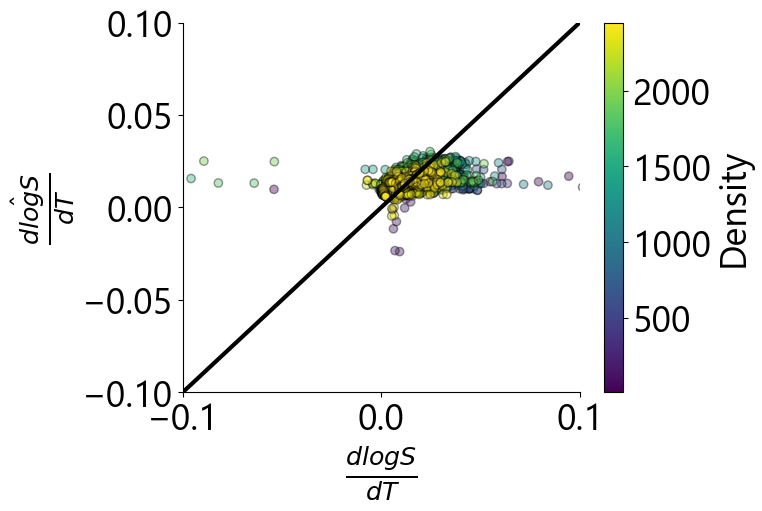

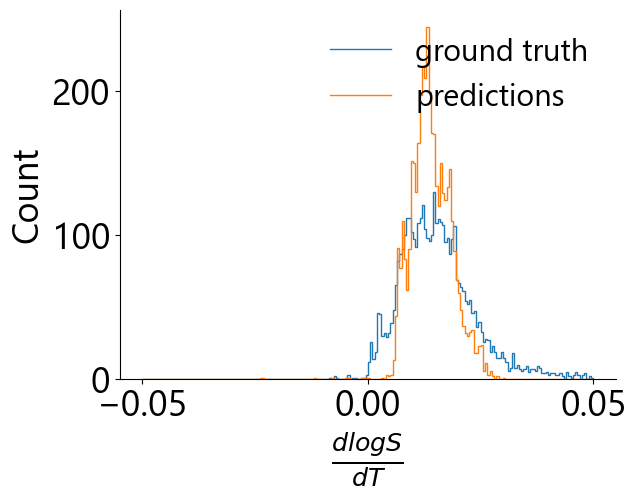

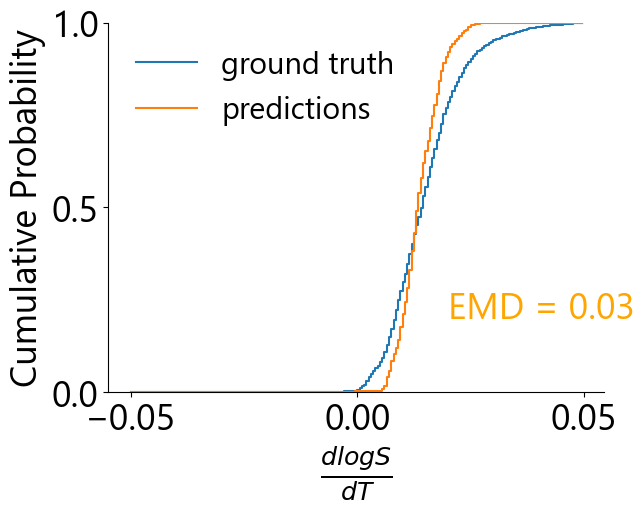

In [113]:
true_grads_ablation, pred_grads_ablation, mse_ablation, mae_ablation = gradient_analysis(ablation_predictions)
gradient_parity_plot(true_grads_ablation, pred_grads_ablation)
ax1, true_grads_binned_ablation, pred_grads_binned_ablation, true_grad_bins_pdf_ablation, pred_grad_bins_pdf_ablation = pdf_plot(true_grads_ablation, pred_grads_ablation, bins =200)
ax2, true_grads_cdf_ablation, pred_grads_cdf_ablation, distance_ablation, true_grad_bins_cdf_ablation, pred_grad_bins_cdf_ablation = cdf_plot(true_grads_ablation, pred_grads_ablation, bins = 200)

In [114]:
mae_ablation

0.008534441651990384

Combined plot

Figure 3

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


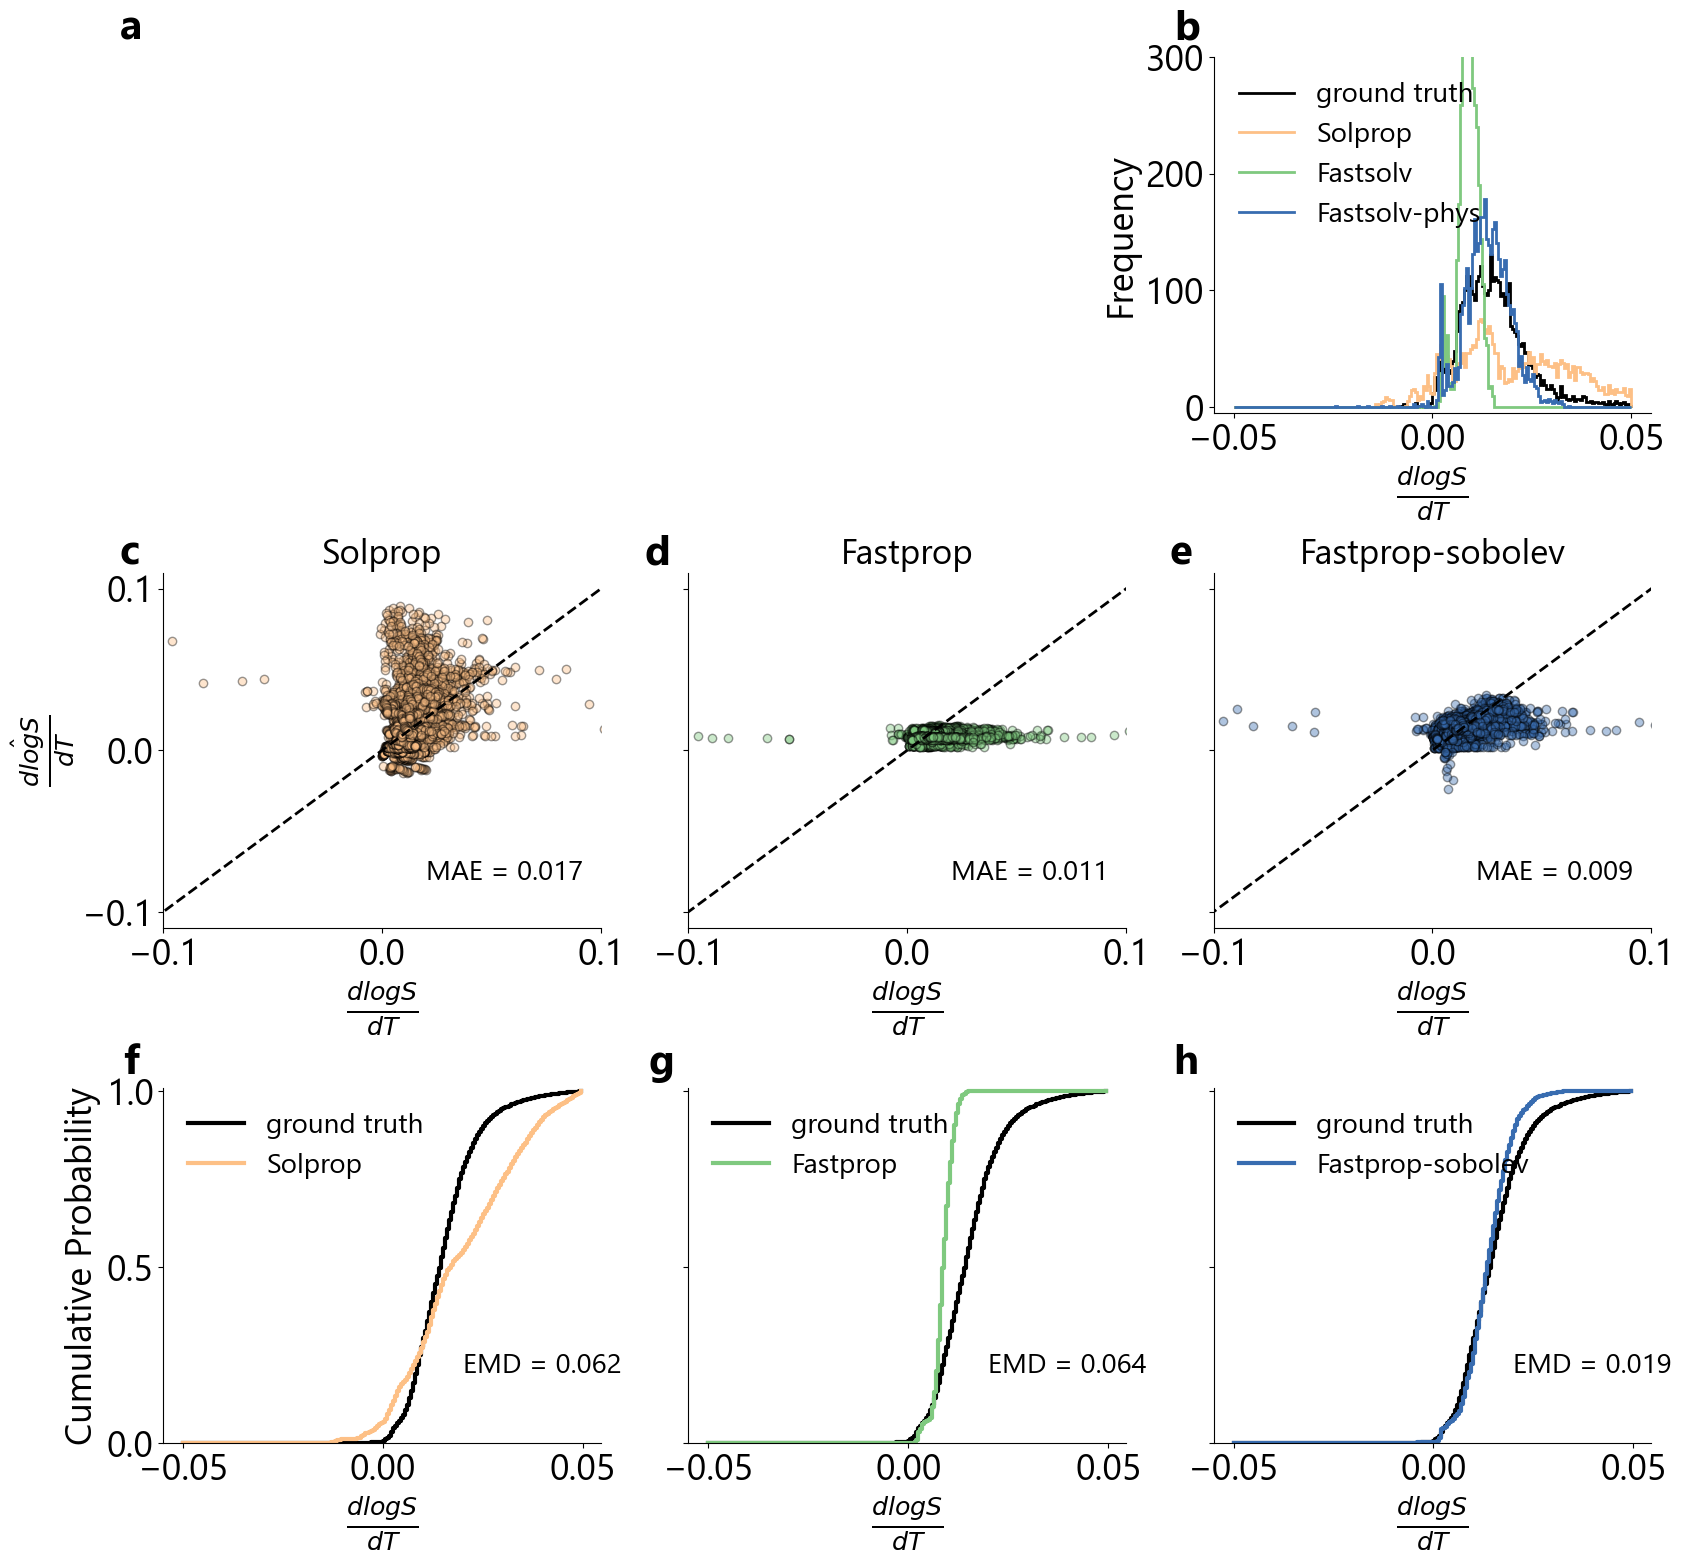

In [101]:
# true_grads_binned, true_grad_bins = np.histogram(true_grads, bins = 200, range = (-0.05, 0.05))
# pred_grads_binned, pred_grad_bins = np.histogram(pred_grads, bins = 200, range = (-0.05, 0.05))
# pred_grads_binned_solprop, pred_grad_bins_solprop = np.histogram(pred_grads_solprop, bins = 200, range = (-0.05, 0.05))
# pred_grads_binned_custom, pred_grad_bins_custom = np.histogram(pred_grads_phys, bins = 200, range = (-0.05, 0.05))

plt.figure(figsize=[6.4*3,4.8*3.75])

ax7 = plt.subplot2grid(shape=(3,3), loc=(0,2), colspan=1)

ax7.stairs(true_grads_binned, true_grad_bins_pdf, linewidth =2, color = 'black', label = r'ground truth')
ax7.stairs(pred_grads_binned_solprop,pred_grad_bins_pdf_solprop, color = colors[2], linewidth =2,label = r'Solprop')
ax7.stairs(pred_grads_binned,pred_grad_bins_pdf, linewidth =2,color = colors[0],label = r'Fastsolv')
ax7.stairs(pred_grads_binned_phys,pred_grad_bins_pdf_phys, color = colors[4],linewidth =2,label = r'Fastsolv-phys')

#ax1.set_xlim([-0.05, 0.05])
ax7.set_ylim([-5, 300])
ax7.set_ylabel(r"Frequency")
ax7.set_xlabel(r"$\frac{dlogS}{dT}$")
ax7.legend(prop={'size': 20}, loc = 'upper left', frameon = False) 
ax7.spines[['right', 'top']].set_visible(False)
ax7.text(-0.065, 300*1.05, "b", weight='bold', fontsize = 30)
ax7.text(-0.33, 300*1.05, "a", weight='bold', fontsize = 30)

plt.subplots_adjust(hspace=0.45)


ax1 = plt.subplot2grid(shape=(3,3), loc=(1,0), colspan=1)
ax1.scatter(true_grads_solprop,pred_grads_solprop, alpha =0.4, color = colors[2], edgecolors = 'black')
ax1.plot([-1, 1], [-1,1], linestyle = '--', linewidth = 2, color = 'black')


ax1.set_xlim([-0.1, 0.1])
ax1.set_ylim([-0.11, 0.11])
ax1.set_ylabel(r"$\frac{\hat{dlogS}}{dT}$")
ax1.set_xticks([-0.1,0 ,0.1])
ax1.set_yticks([-0.1,0 ,0.1])

ax1.set_xlabel(r"$\frac{dlogS}{dT}$")
ax1.legend(prop={'size': 22}, loc = 'upper left', frameon = False) 
ax1.spines[['right', 'top']].set_visible(False)
ax1.set_title("Solprop", fontsize = 25)
ax1.text(0.02,-0.08, f"MAE = {mae_solprop:.3f}", fontsize = 20)
ax1.text(-0.12,0.115, "c", weight='bold', fontsize = 30)


ax2 = plt.subplot2grid(shape=(3,3), loc=(1,1), colspan=1)
ax2.scatter(true_grads,pred_grads, color = colors[0], alpha =0.4, edgecolors = 'black')
ax2.plot([-1, 1], [-1,1], linestyle = '--', linewidth = 2, color = 'black')
ax2.text(0.02,-0.08, f"MAE = {mae:.3f}", fontsize = 20)


ax2.set_xlim([-0.1, 0.1])
ax2.set_xticks([-0.1,0 ,0.1])
ax2.set_yticks([-0.1,0 ,0.1])

ax2.set_ylim([-0.11, 0.11])
#ax2.set_ylabel(r"$\frac{\hat{dlogS}}{dT}$")
ax2.set_yticklabels([])
ax2.set_xlabel(r"$\frac{dlogS}{dT}$")
ax2.legend(prop={'size': 22}, loc = 'upper left', frameon = False) 
ax2.spines[['right', 'top']].set_visible(False)
ax2.set_title("Fastprop", fontsize = 25)
ax2.text(-0.12,0.115, "d", weight='bold', fontsize = 30)


ax3 = plt.subplot2grid(shape=(3,3), loc=(1,2), colspan=1)


ax3.scatter(true_grads_phys,pred_grads_phys,color = colors[4], alpha =0.4, edgecolors = 'black')
ax3.plot([-1, 1], [-1,1], linestyle = '--', linewidth = 2, color = 'black')
ax3.text(0.02,-0.08, f"MAE = {mae_phys:.3f}", fontsize = 20)


ax3.set_xlim([-0.1, 0.1])
ax3.set_xticks([-0.1,0 ,0.1])
ax3.set_yticks([-0.1,0 ,0.1])

ax3.set_ylim([-0.11, 0.11])
#ax3.set_ylabel(r"$\frac{\hat{dlogS}}{dT}$")
ax3.set_yticklabels([])
ax3.set_xlabel(r"$\frac{dlogS}{dT}$")
ax3.legend(prop={'size': 22}, loc = 'upper left', frameon = False) 
ax3.spines[['right', 'top']].set_visible(False)
ax3.set_title("Fastprop-sobolev", fontsize = 25)
ax3.text(-0.12,0.115, "e", weight='bold', fontsize = 30)




# Create the plot
ax4 = plt.subplot2grid(shape=(3,3), loc=(2,0), colspan=1)

# Plot the CDFs as step plots
ax4.step(true_grad_bins_cdf[:-1], true_grads_cdf, linewidth = 3, where='post', color = 'black', label='ground truth')
ax4.step(pred_grad_bins_cdf_solprop[:-1], pred_grads_cdf_solprop, linewidth = 3,color = colors[2], where='post', label='Solprop')
ax4.text(0.02, 0.2, f"EMD = {distance_solprop:.3f}", fontsize = 20)
ax4.text(-0.065, 1.05, "f", weight='bold', fontsize = 30)
# Set axis limits
ax4.set_ylim([0, 1.01])
ax4.set_yticks([0,0.5 ,1])

ax4.set_ylabel("Cumulative Probability")
ax4.set_xlabel(r"$\frac{dlogS}{dT}$")
ax4.legend(prop={'size': 20}, loc='upper left', frameon=False)
ax4.spines[['right', 'top']].set_visible(False)
#ax1.set_title("Solprop", fontsize = 25)



ax5 = plt.subplot2grid(shape=(3,3), loc=(2,1), colspan=1)
ax5.step(true_grad_bins_cdf[:-1], true_grads_cdf, linewidth = 3, where='post', color = 'black', label='ground truth')
ax5.step(pred_grad_bins_cdf[:-1], pred_grads_cdf, where='post', linewidth = 3,color = colors[0], label='Fastprop')
ax5.text(0.02, 0.2, f"EMD = {distance:.3f}", fontsize = 20)
# Set axis limits
ax5.set_ylim([0, 1.01])
ax5.set_yticks([0,0.5 ,1])
ax5.text(-0.065, 1.05, "g", weight='bold', fontsize = 30)

#ax2.set_ylabel("Cumulative Probability")
ax5.set_yticklabels([])
ax5.set_xlabel(r"$\frac{dlogS}{dT}$")
ax5.legend(prop={'size': 20}, loc='upper left', frameon=False)
ax5.spines[['right', 'top']].set_visible(False)
#ax2.set_title("Fastsolv", fontsize = 25)



ax6 = plt.subplot2grid(shape=(3,3), loc=(2,2), colspan=1)
ax6.step(true_grad_bins_cdf[:-1], true_grads_cdf, linewidth = 3, where='post', color = 'black', label='ground truth')
ax6.step(pred_grad_bins_cdf_phys[:-1], pred_grads_cdf_phys,linewidth = 3, where='post', color = colors[4], label='Fastprop-sobolev')
ax6.text(0.02, 0.2, f"EMD = {distance_phys:.3f}", fontsize = 20)
# Set axis limits
ax6.set_ylim([0, 1.01])
ax6.set_yticks([0,0.5 ,1])
ax6.text(-0.065, 1.05, "h", weight='bold', fontsize = 30)

#ax2.set_ylabel("Cumulative Probability")
ax6.set_yticklabels([])
ax6.set_xlabel(r"$\frac{dlogS}{dT}$")
ax6.legend(prop={'size': 20}, loc='upper left', frameon=False)
ax6.spines[['right', 'top']].set_visible(False)
#ax3.set_title("Custom Fastsolv", fontsize = 25)

plt.show()

In [ ]:
# plt.figure(figsize=[6.4*3,4.8])
# ax1 = plt.subplot2grid(shape=(1,3), loc=(0,0), colspan=1)


# bins = [100, 100] # number of bins
# hh, locx, locy = np.histogram2d(true_grads_solprop, pred_grads_solprop, bins=bins, density = True)

# # Sort the points by density, so that the densest points are plotted last
# z = np.array([hh[np.argmax(a<=locx[1:]),np.argmax(b<=locy[1:])] for a,b in zip(true_grads_solprop, pred_grads_solprop)])
# idx = z.argsort()
# x2, y2, z2 = true_grads_solprop[idx], pred_grads_solprop[idx], z[idx]


# ax1.scatter(true_grads_solprop,pred_grads_solprop, c = z2, alpha =0.4, edgecolors = 'black')
# ax1.plot([-1, 1], [-1,1], linestyle = '-', linewidth = 3, color = 'black')

# norm = Normalize(vmin = np.min(z), vmax = np.max(z))
# cbar = fig.colorbar(cm.ScalarMappable(norm = norm), ax=ax1)
# cbar.ax.set_ylabel('Density')


# ax1.set_xlim([-0.1, 0.1])
# ax1.set_ylim([-0.1, 0.1])
# ax1.set_ylabel(r"$\frac{\hat{dlogS}}{dT}$")
# ax1.set_xlabel(r"$\frac{dlogS}{dT}$")
# ax1.legend(prop={'size': 22}, loc = 'upper left', frameon = False) 
# ax1.spines[['right', 'top']].set_visible(False)


# ax2 = plt.subplot2grid(shape=(1,3), loc=(0,1), colspan=1)

# bins = [100, 100] # number of bins
# hh, locx, locy = np.histogram2d(true_grads, pred_grads, bins=bins, density = True)

# # Sort the points by density, so that the densest points are plotted last
# z = np.array([hh[np.argmax(a<=locx[1:]),np.argmax(b<=locy[1:])] for a,b in zip(true_grads, pred_grads)])
# idx = z.argsort()
# x2, y2, z2 = true_grads[idx], pred_grads[idx], z[idx]


# ax2.scatter(true_grads,pred_grads, c = z2, alpha =0.4, edgecolors = 'black')
# ax2.plot([-1, 1], [-1,1], linestyle = '-', linewidth = 3, color = 'black')

# norm = Normalize(vmin = np.min(z), vmax = np.max(z))
# cbar = fig.colorbar(cm.ScalarMappable(norm = norm), ax=ax2)
# cbar.ax.set_ylabel('Density')


# ax2.set_xlim([-0.1, 0.1])
# ax2.set_ylim([-0.1, 0.1])
# #ax2.set_ylabel(r"$\frac{\hat{dlogS}}{dT}$")
# ax2.set_yticklabels([])
# ax2.set_xlabel(r"$\frac{dlogS}{dT}$")
# ax2.legend(prop={'size': 22}, loc = 'upper left', frameon = False) 
# ax2.spines[['right', 'top']].set_visible(False)


# ax3 = plt.subplot2grid(shape=(1,3), loc=(0,2), colspan=1)

# bins = [100, 100] # number of bins
# hh, locx, locy = np.histogram2d(true_grads_custom, pred_grads_custom, bins=bins, density = True)

# # Sort the points by density, so that the densest points are plotted last
# z = np.array([hh[np.argmax(a<=locx[1:]),np.argmax(b<=locy[1:])] for a,b in zip(true_grads_custom, pred_grads_custom)])
# idx = z.argsort()
# x2, y2, z2 = true_grads[idx], pred_grads_custom[idx], z[idx]


# ax3.scatter(true_grads_custom,pred_grads_custom, c = z2, alpha =0.4, edgecolors = 'black')
# ax3.plot([-1, 1], [-1,1], linestyle = '-', linewidth = 3, color = 'black')

# norm = Normalize(vmin = np.min(z), vmax = np.max(z))
# cbar = fig.colorbar(cm.ScalarMappable(norm = norm), ax=ax3)
# cbar.ax.set_ylabel('Density')


# ax3.set_xlim([-0.1, 0.1])
# ax3.set_ylim([-0.1, 0.1])
# #ax3.set_ylabel(r"$\frac{\hat{dlogS}}{dT}$")
# ax3.set_yticklabels([])
# ax3.set_xlabel(r"$\frac{dlogS}{dT}$")
# ax3.legend(prop={'size': 22}, loc = 'upper left', frameon = False) 
# ax3.spines[['right', 'top']].set_visible(False)

